This is my work for CPEN 355 projects. If you change the directory in the methods such that you have all the songs labeled, it should just run directly. 

Introduction:

Take start, middle, end snipet of 10s, break them down into even smaller number, find the FFT number of each interested frequency. Maybe compress it to reduce burden? 

Import the linraries I want to use  

In [26]:
import eyed3
from pydub import AudioSegment
import numpy as np
import os
#import audio2numpy as a2n
import pandas as pd
import librosa
import librosa.display
import csv

Normal approach of analyzing a audio file might need to apply FFT from 20Hz to 20000Hz (The sound range of most humans). For this project, to save my GPU's life, I will just check for the most used notes with the respected frequency. 

Not checking the frequencies between the notes would eliminate some information but that should not be a major issue. 

In [27]:
# Dictionary to store musical notes and their frequencies
musical_notes = {
    'A1': 55.0,
    'A#1/Bb1': 58.27,
    'B1': 61.74,
    'C2': 65.41,
    'C#2/Db2': 69.3,
    'D2': 73.42,
    'D#2/Eb2': 77.78,
    'E2': 82.41,
    'F2': 87.31,
    'F#2/Gb2': 92.5,
    'G2': 98.0,
    'G#2/Ab2': 103.83,
    'A2': 110.0,
    'A#2/Bb2': 116.54,
    'B2': 123.47,
    'C3': 130.81,
    'C#3/Db3': 138.59,
    'D3': 146.83,
    'D#3/Eb3': 155.56,
    'E3': 164.81,
    'F3': 174.61,
    'F#3/Gb3': 185.0,
    'G3': 196.0,
    'G#3/Ab3': 207.65,
    'A3': 220.0,
    'A#3/Bb3': 233.08,
    'B3': 246.94,
    'C4': 261.63,
    'C#4/Db4': 277.18,
    'D4': 293.66,
    'D#4/Eb4': 311.13,
    'E4': 329.63,
    'F4': 349.23,
    'F#4/Gb4': 369.99,
    'G4': 392.0,
    'G#4/Ab4': 415.3,
    'A4': 440.0,
    'A#4/Bb4': 466.16,
    'B4': 493.88,
    'C5': 523.25,
    'C#5/Db5': 554.37,
    'D5': 587.33,
    'D#5/Eb5': 622.25,
    'E5': 659.26,
    'F5': 698.46,
    'F#5/Gb5': 739.99,
    'G5': 783.99,
    'G#5/Ab5': 830.61,
    'A5': 880.0,
    'A#5/Bb5': 932.33,
    'B5': 987.77,
    'C6': 1046.5,
    'C#6/Db6': 1108.73,
    'D6': 1174.66,
    'D#6/Eb6': 1244.51,
    'E6': 1318.51,
    'F6': 1396.91,
    'F#6/Gb6': 1479.98,
    'G6': 1567.98,
    'G#6/Ab6': 1661.22,
    'A6': 1760.0,
    'A#6/Bb6': 1864.66,
    'B6': 1975.53,
    'C7': 2093.0,
}

Write methods to read MP3 file

read_mp3_songs(path): finds all the mp3 files and keep their address

get_mp3_info(mp3_filename): finds the start middle and end 10s of snipets. (Again not analyzing the whole song to save my computer)

get_mp3_info(mp3_filename): finds the artist and song name. (Supervised Learning purpose)

calculate_fft(segment, sampling_rate): FFT function

In [28]:
# Function to get the artist and title info
def get_mp3_info(mp3_filename):
    # Initialize Eyed3
    audiofile = eyed3.load(mp3_filename)

    # Get artist and genre from the MP3 file's metadata
    artist = audiofile.tag.artist
    #genre = audiofile.tag.genre.name
    title = audiofile.tag.title

    return artist, title

# Function to get snippets of start mid and end 10s. Then apply FFT to get interested frequency data, store them into seprate .csv files. 
# Note that for start and end, I skipped 10s since usually they do not contain information
def generate_audio_snippets(mp3_filename):
    
    # Check if it is unlabeld. 
    artist, title = get_mp3_info(mp3_filename)
    if title == None:
        title = os.path.basename(mp3_filename)
    if artist == None:
        artist = 'unkown'
    output_file_path = os.path.dirname(mp3_filename)
    
    # If the file already exists, skip it
    if os.path.exists(output_file_path + '\start\\' + title + '.csv'):
        return
    
    # Load the MP3 file
    print(mp3_filename)
    mp3_file, sampling_rate = librosa.load(mp3_filename)
    
    
    # Check if the folder exists
    if not os.path.exists(output_file_path + '\start'):
        # If it doesn't exist, create the folder
        os.makedirs(output_file_path + '\start')
        os.makedirs(output_file_path + '\mid')
        os.makedirs(output_file_path + '\end')

    
        
    
        
    # Calculate the start and end points for the 10-second snippets
    duration = 10 * sampling_rate  # 10 seconds of samples
    center = len(mp3_file) // 2  # Calculate the center of the audio

    # Start and end times for snippets
    start_times = [duration, center - duration // 2, len(mp3_file) - duration * 2]
    end_times = [duration * 2, center + duration // 2, len(mp3_file) - duration]
    start, mid, end = [],[],[]
    
    start = mp3_file[start_times[0]:end_times[0]]
    mid = mp3_file[start_times[1]:end_times[1]]
    end = mp3_file[start_times[2]:end_times[2]]
    
    # Normalize the audio data to the range [-1, 1]
    start = 2 * (start - min(start)) / (max(start) - min(start)) - 1
    mid = 2 * (mid - min(mid)) / (max(mid) - min(mid)) - 1
    end = 2 * (end - min(end)) / (max(end) - min(end)) - 1
    
    # Calculate the number of samples per chunk
    chunk_duration = 0.08  # in seconds
    samples_per_chunk = int(sampling_rate * chunk_duration)
    
    # Extract chunks and apply FFT
    results = []

    for i in range(0, len(start) - samples_per_chunk, samples_per_chunk):
        chunk = start[i:i + samples_per_chunk]
        fft_result = calculate_fft(chunk, sampling_rate)
        results.append(fft_result)
        
    df_results = pd.DataFrame(results)
    
    csv_path = output_file_path + '\start\\' + title + '.csv'
    # Save the DataFrame to a new CSV file
    with open(csv_path, 'w', newline='') as csv_file:
        df_results.to_csv(csv_path, index=False)
      
    # Time for mid  
    results.clear
    
    for i in range(0, len(start) - samples_per_chunk, samples_per_chunk):
        chunk = mid[i:i + samples_per_chunk]
        fft_result = calculate_fft(chunk, sampling_rate)
        results.append(fft_result)
    
    csv_path = output_file_path + '\mid\\' + title + '.csv'    
    # Save the DataFrame to a new CSV file
    with open(csv_path, 'w', newline='') as csv_file:
        df_results.to_csv(csv_path, index=False)
       
    # Time for end 
    results.clear
    
    for i in range(0, len(start) - samples_per_chunk, samples_per_chunk):
        chunk = end[i:i + samples_per_chunk]
        fft_result = calculate_fft(chunk, sampling_rate)
        results.append(fft_result)
    
    csv_path = output_file_path + '\end\\' + title + '.csv'
    # Save the DataFrame to a new CSV file
    with open(csv_path, 'w', newline='') as csv_file:
        df_results.to_csv(csv_path, index=False)
    
    return

# Function to get all paths for my mp3 files
def read_mp3_songs(path):
    # Get the path of all songs given the song foler.
    # Checks each foler in the given folder. 
    mp3_songs = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".mp3"):
                mp3_path = os.path.join(root, file)
                mp3_songs.append(mp3_path)

    return mp3_songs

# Function to calculate FFT and extract amplitudes for musical notes
def calculate_fft(segment, sampling_rate):
    fft_result = np.fft.fft(segment)
    frequencies = np.fft.fftfreq(len(segment), d=1/sampling_rate)
    
    # Dictionary to store amplitude for each musical note
    amplitudes = {note: np.abs(fft_result[np.abs(frequencies - freq).argmin()]) for note, freq in musical_notes.items()}
    
    return amplitudes


In [29]:

songs_path = r"G:\Songs"  # Where I store files

mp3_songs = read_mp3_songs(songs_path) # Now all mp3 file path are in here
count = 0

# Now all data in .csv I can start machine learning. Once they are in there, I do not need to regenerate the analyzed data anymore. 
for mp3_path in mp3_songs:
    count = count + 1
    generate_audio_snippets(mp3_path)
    
print("Finished generating .csv file")
print(str(count))


Lame tag CRC check failed
Invalid numeric genre ID: 255
Unknown genre ID: 255
Invalid numeric genre ID: 255
Unknown genre ID: 255
Invalid numeric genre ID: 255
Unknown genre ID: 255


Finished generating .csv file
218


Before training start, to further save my computer, I use PCA to reduce dimensionality:

To decide how many components I want to use, I pull out a sigle file and calculate it with different components and test for the performance.

In [50]:
#Test filed to find the reaonable number of components to reach about 70% of the variance. Reduce the dimension of the data and training time.
'''"Project report.aux"'
# Do not run this in training. It is just for testing purpose.

# Read the data from the CSV file
directory = r"G:\\Songs\\AAA\\start\\Hello.csv"
filepaths = os.path.join(directory)
df = pd.read_csv(filepaths).T

# Print the shape of the DataFrame
print(df.shape)

#Check the cumulative variance for each number of components
for k in range(5, 60, 5):
    pca = PCA(n_components=k)
    reduced_data = pca.fit_transform(df)
    cumulative_var = np.sum(pca.explained_variance_ratio_[:k + 1])
    print(k, cumulative_var)
#cumulative_var = np.sum(pca.explained_variance_ratio_[:k + 1])

pca = PCA(n_components=10)
reduced_data = pca.fit_transform(df)
# Define the output file path
output_file_path = os.path.join(r"G:\\Songs\\AAA\\", "reduced_data.csv")

# Create a DataFrame from the reduced data
reduced_df = pd.DataFrame(reduced_data)

# Save the DataFrame to a new CSV file
reduced_df.to_csv(output_file_path, index=False)

print(reduced_data.shape)
print(reduced_data)
'''
'''"Project report.aux"
5 0.7254756251686398
10 0.8747829463301018
15 0.93963397065257
20 0.9707914244773223
25 0.9860049325538303
30 0.9927169174060696
35 0.9964934674252495
40 0.9986133518375307
45 0.999622615506004
50 0.9999261757883421
55 1.0000000000000002
'''
# 10 components are good enough for me now. Apply 10 to the rest of the data.


(64, 124)
5 0.7622643349134097
10 0.8900002447246864
15 0.9469214522773146
20 0.9747891903428441
25 0.9878881694342643
30 0.9938506035941943
35 0.9970978976930218
40 0.9989502181218164
45 0.9997231555562979
50 0.9999554205415617
55 1.0
(64, 10)
[[-6.47276460e+01 -4.52118112e+01 -8.17700298e-01 -2.36790238e+01
   8.36172925e-01 -1.32682259e+01 -8.30046453e+00 -1.82569662e+00
  -7.03011194e+00  9.05113930e+00]
 [-5.98627802e+01 -3.08017412e+01 -1.07474558e+01 -1.43085606e+01
  -5.77663421e+00 -1.75566864e+01 -2.33456976e+00 -8.02911719e-01
  -1.35918023e+01  7.84007166e+00]
 [-5.98627802e+01 -3.08017412e+01 -1.07474558e+01 -1.43085606e+01
  -5.77663421e+00 -1.75566864e+01 -2.33456976e+00 -8.02911719e-01
  -1.35918023e+01  7.84007166e+00]
 [-5.98627802e+01 -3.08017412e+01 -1.07474558e+01 -1.43085606e+01
  -5.77663421e+00 -1.75566864e+01 -2.33456976e+00 -8.02911719e-01
  -1.35918023e+01  7.84007166e+00]
 [-3.32215318e+01  7.75152264e+01 -1.87871254e+01  1.64132110e+01
  -4.91307213e+01 -1.

'"Project report.aux"\n5 0.7254756251686398\n10 0.8747829463301018\n15 0.93963397065257\n20 0.9707914244773223\n25 0.9860049325538303\n30 0.9927169174060696\n35 0.9964934674252495\n40 0.9986133518375307\n45 0.999622615506004\n50 0.9999261757883421\n55 1.0000000000000002\n'

Since I will use the same training strategy three times, I would rather just define the similar procedures as funtions for clarity:

Now I will define the PCA, SVM and NN functions below:

In [31]:
from sklearn.decomposition import PCA

# folder is the folder name. For example, start, mid, end
# PCA_10 is the function to reduce the dimension of the data to 10.
def PCA_10 (folder):
    # Define the directory path
    directory = r"G:\Songs"

    # Initialize an empty dictionary to store the reduced data
    reduced_data = {}
    reduced_testing_data = {}
    # check the start folder only in this case

    for singer in os.listdir(directory):
        # Skip unlabelled singers
        if singer == "Unlabeled":
            print("Prepare the testing data")
            
            for filename in os.listdir(os.path.join(directory, singer, folder)):
                #print("Processing file", filename)
                if filename.endswith(".csv"):
                    
                    # Construct the file path
                    filepath = os.path.join(os.path.join(directory, singer, folder, filename))
                    
                    # Read the .csv file into a dataframe
                    df = pd.read_csv(filepath)
                    
                    # Apply PCA to reduce the dimension of the data
                    pca = PCA(n_components=10)  
                    reduce = pca.fit_transform(df)
                    
                    # For testing data, the singer label is the filename. So after prediction, it need to compare with the filename. 
                    reduced_testing_data[filename] = [reduce]
        else:
            print("Processing singer", singer)
            # Singer directories
            for filename in os.listdir(os.path.join(directory, singer, folder)):
                #print("Processing file", filename)
                if filename.endswith(".csv"):
                    
                    # Construct the file path
                    filepath = os.path.join(os.path.join(directory, singer, folder, filename))
                    
                    # Read the .csv file into a dataframe
                    df = pd.read_csv(filepath)
                    
                    # Apply PCA to reduce the dimension of the data
                    pca = PCA(n_components=10)  
                    reduce = pca.fit_transform(df)
                    
                    # Get the singer label from the folder name
                    singer_label = singer
                    
                    # Check if the singer label already exists in the dictionary
                    if singer_label in reduced_data:
                        # Append the dataframe to the existing list
                        reduced_data[singer_label].append(reduce)
                    else:
                        # Create a new list with the dataframe
                        reduced_data[singer_label] = [reduce]

    # Now all the data here are ready to train.

    # Prepare the data for training
    X = []
    y = []
    X_test = []
    y_test = []


    # Iterate over the reduced_data dictionary
    for label, data in reduced_data.items():
        # Append the reduced data to X
        X.extend(data)
        # Append the label to y
        y.extend([label] * len(data))

    # Also get the testing data
    for label, data in reduced_testing_data.items():

        X_test.extend(data)
        
        y_test.extend([label] * len(data))
        
    # At this point, X = (207,124,10) Need to reshape it to (207,1240)
    # Reshape X to (207, 1240)
    X = np.array(X).reshape(len(X), -1)
    X_test = np.array(X_test).reshape(len(X_test), -1)
    # print("Dimension of y:", np.array(y).shape)
    # print("Dimension of x:", np.array(X).shape)
    # print("Dimension of y_test:", np.array(y_test).shape)
    # print("Dimension of x_test:", np.array(X_test).shape)
    
    # Return the data that is reduced by PCA
    return X, y, X_test, y_test


In [32]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Now train the model with SVM, figure out the best parameter and the best prediction accuracy
def SVM_Search(X, y, X_test, y_test):
    # Define the parameter grid
    param_grid = {
        'C': [0.1, 1, 5, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        #'gamma': [0.1, 1, 10, 'auto']
    }

    # Create an SVM classifier
    svm = SVC()

    # Perform grid search to find the best parameters
    print("Performing grid search...")
    grid_search = GridSearchCV(svm, param_grid, cv=5)
    print("Fitting the grid search...")
    grid_search.fit(X, y)


    clear_output()
    # Print the best parameters
    print("Best parameters:", grid_search.best_params_)

    # Train the SVM classifier with the best parameters
    svm = grid_search.best_estimator_
    
    # Predict the labels for the test data
    y_pred = svm.predict(X_test)

    # Check if y_pred is in y_test
    contains_pred = []

    # Print the pairs and check if y_test contains y_pred
    for pred, test in zip(y_pred, y_test):
        print("y_pred:", pred)
        print("y_test:", test)
        contains_pred.append(pred in test)
        
    # Create an array of all True values with the same size as contains_pred
    all_true = np.full_like(contains_pred, True)
    # Calculate the accuracy of the model
    accuracy = accuracy_score(all_true, contains_pred)

    # Print the accuracy
    print("Accuracy on test set:", accuracy)
    
    return accuracy, grid_search.best_params_



In [33]:
# Seems like tensorflow does not work with GridSearchCV. Need to guess the best parameters and do it manually.
import tensorflow as tf
from IPython.display import clear_output

# Now train the model with NN, figure out the best parameter and the best prediction accuracy
def NN_Search(X,y,X_test,y_test):
    # Define the parameter grid to search manually
    param_grid = {
        'units': [16, 32, 64, 128, 256],
        'epochs': [5, 10, 20, 30],
        'batch_size': [16, 32, 64]
    }

    # Use these to collect the best parameters
    best_accuracy = 0
    best_params_ = None
    self_accuracy = 0
    best_model = None

    # For some reason, it seems like tensorflow does not like string, need to convert y to float.
    dictionary = {}
    number = 0
    for singer in y:
        if singer not in dictionary:
            dictionary[singer] = number
            number = number + 1
        
    y_tensor = [dictionary[singer] for singer in y]

    # Do the same thing for y_test, but need to check with the file name instead
    y_test_tensor = []

    for filename in y_test:
        for singer in dictionary:
            if singer in filename:
                y_test_tensor.append(dictionary[singer])
                break

    # Convert X, y, X_test, and y_test to tensors
    X_tensor = tf.convert_to_tensor(X)
    y_tensor = tf.convert_to_tensor(y_tensor)
    X_test_tensor = tf.convert_to_tensor(X_test)
    y_test_tensor = tf.convert_to_tensor(y_test_tensor)


    for units in param_grid['units']:
        for epochs in param_grid['epochs']:
            for batch_size in param_grid['batch_size']:
                # Create a model
                model = tf.keras.models.Sequential([
                    tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
                    tf.keras.layers.Dense(units, activation='relu'),
                    # Seems like the line below could limit the output to be 16, which is the number of singers.
                    tf.keras.layers.Dense(16, activation=tf.keras.activations.softmax, name='output')
                    # Not sure how exactly it works, but it works.
                ])
                model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
                
                # Train the model
                model.fit(X, y_tensor, epochs=epochs, batch_size=batch_size)
                
                # Evaluate the model on the test set
                result = model.evaluate(X, y_tensor)
                print(result)
                
                if (result[1] > self_accuracy):
                    self_accuracy = result[1]
                
                result = model.evaluate(X_test, y_test_tensor)
                print(result)
                
                if (result[1] > best_accuracy):
                    best_model = model
                    best_accuracy = result[1]
                    best_params_ = (units, epochs, batch_size)
                    
                    
    # Just show the results here, do not show the Tensorflow training output             
    clear_output()

    print("Best parameters:", best_params_)
    print("Best accuracy:", best_accuracy)

    model = best_model

    # predict the labels for the test data
    y_pred_tensor = model.predict(X_test_tensor)
    y_pred_tensor = tf.argmax(y_pred_tensor, axis=1).numpy()

    y_pred = []

    # Find the corresponding key in the dictionary and replace the value
    for i in range(len(y_pred_tensor)):
        found_match = False
        for key, value in dictionary.items():
            if value == y_pred_tensor[i]:
                y_pred.append(key)
                found_match = True
                break
        if not found_match:
            # This is here because before the NN model would predict sth out of the dictionary
            # Now it should not happen anymore
            y_pred.append("unknown")
        

    # Print the predictions and the actual labels
    for pred_tensor, test_tensor in zip(y_pred, y_test):
        print("y_pred_tensor:", pred_tensor)
        print("y_test_tensor:", test_tensor)
        
    # Print the accuracy
    #print("Best accuracy on self: ", self_accuracy)
    
    return best_accuracy, best_params_

Now apply PCA to the 'start' data

In [34]:
X, y, X_test, y_test = PCA_10('start')

Processing singer AAA
Prepare the testing data


Processing singer 五月天
Processing singer 吴青峰
Processing singer 周杰伦
Processing singer 声音玩具
Processing singer 康士坦的变化球
Processing singer 张学友
Processing singer 方大同
Processing singer 杨乃文
Processing singer 林俊杰
Processing singer 林忆莲
Processing singer 王力宏
Processing singer 王菲
Processing singer 重塑雕像的权利
Processing singer 陈奕迅
Processing singer 陶喆


Apply SVM on the 'start' data

In [35]:
start_SVM_acc, start_SVM_param = SVM_Search(X, y, X_test, y_test)

Best parameters: {'C': 1, 'kernel': 'rbf'}
y_pred: 周杰伦
y_test: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred: 王菲
y_test: 周杰伦 - 美人鱼.mp3.csv
y_pred: 周杰伦
y_test: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred: 张学友
y_test: 方大同 - Love Song.mp3.csv
y_pred: 方大同
y_test: 方大同 - 好不容易.mp3.csv
y_pred: 张学友
y_test: 方大同 - 红豆.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 她说.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 学不会.mp3.csv
y_pred: 周杰伦
y_test: 王菲 - 当时的月亮.mp3.csv
y_pred: 王菲
y_test: 陶喆 - 黑色柳丁.mp3.csv
Accuracy on test set: 0.3


Apply NN on the 'start' data

In [36]:
start_NN_acc, start_NN_param = NN_Search(X, y, X_test, y_test)

Best parameters: (32, 30, 32)
Best accuracy: 0.5
1/1 [==============================] - 0s 74ms/step
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦 - 美人鱼.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred_tensor: 五月天
y_test_tensor: 方大同 - Love Song.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 方大同 - 好不容易.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 方大同 - 红豆.mp3.csv
y_pred_tensor: 张学友
y_test_tensor: 林俊杰 - 她说.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 林俊杰 - 学不会.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 王菲 - 当时的月亮.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 陶喆 - 黑色柳丁.mp3.csv


Now apply PCA to the 'mid' data

In [37]:
X, y, X_test, y_test = PCA_10('mid')

Processing singer AAA


Prepare the testing data
Processing singer 五月天
Processing singer 吴青峰
Processing singer 周杰伦
Processing singer 声音玩具
Processing singer 康士坦的变化球
Processing singer 张学友
Processing singer 方大同
Processing singer 杨乃文
Processing singer 林俊杰
Processing singer 林忆莲
Processing singer 王力宏
Processing singer 王菲
Processing singer 重塑雕像的权利
Processing singer 陈奕迅
Processing singer 陶喆


Apply SVM on the 'mid' data

In [38]:
mid_SVM_acc, mid_SVM_param = SVM_Search(X, y, X_test, y_test)

Best parameters: {'C': 1, 'kernel': 'rbf'}
y_pred: 周杰伦
y_test: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred: 王菲
y_test: 周杰伦 - 美人鱼.mp3.csv
y_pred: 周杰伦
y_test: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred: 张学友
y_test: 方大同 - Love Song.mp3.csv
y_pred: 方大同
y_test: 方大同 - 好不容易.mp3.csv
y_pred: 张学友
y_test: 方大同 - 红豆.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 她说.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 学不会.mp3.csv
y_pred: 周杰伦
y_test: 王菲 - 当时的月亮.mp3.csv
y_pred: 王菲
y_test: 陶喆 - 黑色柳丁.mp3.csv
Accuracy on test set: 0.3


Apply NN on the 'mid' data

In [39]:
mid_NN_acc, mid_NN_param = NN_Search(X, y, X_test, y_test)

Best parameters: (256, 30, 32)
Best accuracy: 0.4000000059604645
1/1 [==============================] - 0s 72ms/step
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 周杰伦 - 美人鱼.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred_tensor: 王菲
y_test_tensor: 方大同 - Love Song.mp3.csv
y_pred_tensor: 王力宏
y_test_tensor: 方大同 - 好不容易.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 方大同 - 红豆.mp3.csv
y_pred_tensor: 林俊杰
y_test_tensor: 林俊杰 - 她说.mp3.csv
y_pred_tensor: 王力宏
y_test_tensor: 林俊杰 - 学不会.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 王菲 - 当时的月亮.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 陶喆 - 黑色柳丁.mp3.csv


Now apply PCA to the 'end' data

In [40]:
X, y, X_test, y_test = PCA_10('end')

Processing singer AAA


Prepare the testing data
Processing singer 五月天
Processing singer 吴青峰
Processing singer 周杰伦
Processing singer 声音玩具
Processing singer 康士坦的变化球
Processing singer 张学友
Processing singer 方大同
Processing singer 杨乃文
Processing singer 林俊杰
Processing singer 林忆莲
Processing singer 王力宏
Processing singer 王菲
Processing singer 重塑雕像的权利
Processing singer 陈奕迅
Processing singer 陶喆


Apply SVM on the 'end' data

In [41]:
end_SVM_acc, end_SVM_param = SVM_Search(X, y, X_test, y_test)

Best parameters: {'C': 1, 'kernel': 'rbf'}
y_pred: 周杰伦
y_test: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred: 王菲
y_test: 周杰伦 - 美人鱼.mp3.csv
y_pred: 周杰伦
y_test: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred: 张学友
y_test: 方大同 - Love Song.mp3.csv
y_pred: 方大同
y_test: 方大同 - 好不容易.mp3.csv
y_pred: 张学友
y_test: 方大同 - 红豆.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 她说.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 学不会.mp3.csv
y_pred: 周杰伦
y_test: 王菲 - 当时的月亮.mp3.csv
y_pred: 王菲
y_test: 陶喆 - 黑色柳丁.mp3.csv
Accuracy on test set: 0.3


Apply NN on the 'end' data

In [42]:
end_NN_acc, end_NN_param = NN_Search(X, y, X_test, y_test)

Best parameters: (128, 20, 64)
Best accuracy: 0.6000000238418579
1/1 [==============================] - 0s 80ms/step
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred_tensor: 王力宏
y_test_tensor: 周杰伦 - 美人鱼.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 方大同 - Love Song.mp3.csv
y_pred_tensor: 周杰伦
y_test_tensor: 方大同 - 好不容易.mp3.csv
y_pred_tensor: 陈奕迅
y_test_tensor: 方大同 - 红豆.mp3.csv
y_pred_tensor: 林俊杰
y_test_tensor: 林俊杰 - 她说.mp3.csv
y_pred_tensor: 张学友
y_test_tensor: 林俊杰 - 学不会.mp3.csv
y_pred_tensor: 王菲
y_test_tensor: 王菲 - 当时的月亮.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 陶喆 - 黑色柳丁.mp3.csv


The result is too similar and it is not what I would expect it to be. I am expecting a higher accuracy. So now, I try to train with all three snippets and then add cross validation if possible


In [43]:
from sklearn.decomposition import PCA

# Get the data from all three folders
def PCA_10_all():
    # Define the directory path
    directory = r"G:\Songs"

    # Initialize an empty dictionary to store the reduced data
    reduced_data = {}
    reduced_testing_data = {}
    # check the start folder only in this case

    for singer in os.listdir(directory):
        # Skip unlabelled singers
        if singer == "Unlabeled":
            print("Prepare the testing data")
            
            for folder in os.listdir(os.path.join(directory, singer)):
                # make sure it is a folder
                folder_path = os.path.join(directory, singer, folder)
                if os.path.isdir(folder_path):
                    #print("Processing folder", folder)
                    for filename in os.listdir(folder_path):
                        #print("Processing file", filename)
                        if filename.endswith(".csv"):
                            # Construct the file path
                            filepath = os.path.join(folder_path, filename)
                            
                            # Read the .csv file into a dataframe
                            df = pd.read_csv(filepath)
                            
                            # Apply PCA to reduce the dimension of the data
                            pca = PCA(n_components=10)  
                            reduce = pca.fit_transform(df)
                            
                            # For testing data, the singer label is the filename. So after prediction, it needs to compare with the filename. 
                            if filename in reduced_testing_data:
                                # If the label exists in the dictionary, concatenate the arrays
                                existing_array = reduced_testing_data[filename]
                                combined_array = np.concatenate([existing_array, reduce], axis=0)
                                reduced_testing_data[filename] = combined_array
                                #print(combined_array.shape)
                            else:
                                # Create a new list with the dataframe
                                reduced_testing_data[filename] = reduce
        else:
            print("Processing singer", singer)
            # Singer directories
            
            # Initialize an empty dictionary to store the reduced data
            song_look_up = {}
            for folder in os.listdir(os.path.join(directory, singer)):
                
                folder_path = os.path.join(directory, singer, folder)
                if os.path.isdir(folder_path):
                    #print("Processing folder", folder)
                    for filename in os.listdir(folder_path):
                        #print("Processing file", filename)
                        if filename.endswith(".csv"):
                            # Construct the file path
                            filepath = os.path.join(folder_path, filename)
                            
                            # Read the .csv file into a dataframe
                            df = pd.read_csv(filepath)
                            
                            # Apply PCA to reduce the dimension of the data
                            pca = PCA(n_components=10)  
                            reduce = pca.fit_transform(df)
                            
                            if filename in song_look_up:
                                # If the label exists in the dictionary, concatenate the arrays
                                existing_array = song_look_up[filename]
                                combined_array = np.concatenate([existing_array, reduce], axis=0)
                                song_look_up[filename] = combined_array
                                #print(combined_array.shape)
                            else:
                                # Create a new list with the dataframe
                                song_look_up[filename] = reduce
                
            # Get the singer label from the folder name
            singer_label = singer
            
            # add all the data from the song_look_up dictionary to the reduced_data dictionary
            reduced_data[singer_label] = []
            
            # Iterate over the song_look_up dictionary
            for label, data in song_look_up.items():
                # Append the reduced data to X
                reduced_data[singer_label].append(data)
                #print("Dimension of data:", np.array(data).shape)

    # Now all the data here are ready to train.

    # Prepare the data for training
    X = []
    y = []
    X_test = []
    y_test = []

    # Iterate over the reduced_data dictionary
    for label, data in reduced_data.items():
        # Append the reduced data to X
        X.extend(data)
        # Append the label to y
        y.extend([label] * len(data))


    print(reduced_testing_data.keys())
    print(reduced_testing_data.values())
    # Also get the testing data
    for label, data in reduced_testing_data.items():
        X_test.append(data)
        y_test.append(label)
        
    # At this point, X = (207,124,10) Need to reshape it to (207,1240)
    # Reshape X to (207, 1240)
    X = np.array(X).reshape(len(X), -1)
    X_test = np.array(X_test).reshape(len(X_test), -1)
    # print("Dimension of y:", np.array(y).shape)
    # print("Dimension of x:", np.array(X).shape)
    # print("Dimension of y_test:", np.array(y_test).shape)
    # print("Dimension of x_test:", np.array(X_test).shape)
    
    # Return the data that is reduced by PCA
    return X, y, X_test, y_test


In [44]:
X, y, X_test, y_test = PCA_10_all()
'''
print("Dimension of X:", np.array(X).shape)
print(X)
print("Dimension of y:", np.array(y).shape)
print(y)
print("Dimension of X_test:", np.array(X_test).shape)
print(X_test)
print("Dimension of y_test:", np.array(y_test).shape)
print(y_test)
'''

Processing singer AAA


Prepare the testing data
Processing singer 五月天
Processing singer 吴青峰
Processing singer 周杰伦
Processing singer 声音玩具
Processing singer 康士坦的变化球
Processing singer 张学友
Processing singer 方大同
Processing singer 杨乃文
Processing singer 林俊杰
Processing singer 林忆莲
Processing singer 王力宏
Processing singer 王菲
Processing singer 重塑雕像的权利
Processing singer 陈奕迅
Processing singer 陶喆
dict_keys(['周杰伦 - 听见下雨的声音.mp3.csv', '周杰伦 - 美人鱼.mp3.csv', '周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv', '方大同 - Love Song.mp3.csv', '方大同 - 好不容易.mp3.csv', '方大同 - 红豆.mp3.csv', '林俊杰 - 她说.mp3.csv', '林俊杰 - 学不会.mp3.csv', '王菲 - 当时的月亮.mp3.csv', '陶喆 - 黑色柳丁.mp3.csv'])
dict_values([array([[-51.87849508, -60.16807359,  -5.01478259, ...,  -2.57256638,
          1.27569282,   6.79853216],
       [-43.95747796, -52.22677898, -12.2041698 , ...,  -3.78801746,
         -3.82582278, -15.30169152],
       [-40.45568227, -57.61629335, -16.29715325, ...,  -5.73669795,
        -16.46471565, -63.41656665],
       ...,
       [ 21.73248212, 165.33404478, -56.65772229

'\nprint("Dimension of X:", np.array(X).shape)\nprint(X)\nprint("Dimension of y:", np.array(y).shape)\nprint(y)\nprint("Dimension of X_test:", np.array(X_test).shape)\nprint(X_test)\nprint("Dimension of y_test:", np.array(y_test).shape)\nprint(y_test)\n'

In [45]:
all_SVM_acc, all_SVM_param = SVM_Search(X, y, X_test, y_test)

Best parameters: {'C': 1, 'kernel': 'rbf'}
y_pred: 周杰伦
y_test: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred: 王菲
y_test: 周杰伦 - 美人鱼.mp3.csv
y_pred: 周杰伦
y_test: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred: 张学友
y_test: 方大同 - Love Song.mp3.csv
y_pred: 方大同
y_test: 方大同 - 好不容易.mp3.csv
y_pred: 张学友
y_test: 方大同 - 红豆.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 她说.mp3.csv
y_pred: 方大同
y_test: 林俊杰 - 学不会.mp3.csv
y_pred: 周杰伦
y_test: 王菲 - 当时的月亮.mp3.csv
y_pred: 王菲
y_test: 陶喆 - 黑色柳丁.mp3.csv
Accuracy on test set: 0.3


In [46]:
all_NN_acc, all_NN_param = NN_Search(X, y, X_test, y_test)

Best parameters: (16, 30, 32)
Best accuracy: 0.6000000238418579
1/1 [==============================] - 0s 85ms/step
y_pred_tensor: 周杰伦
y_test_tensor: 周杰伦 - 听见下雨的声音.mp3.csv
y_pred_tensor: 林忆莲
y_test_tensor: 周杰伦 - 美人鱼.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 周杰伦、张惠妹 - 不该 (with aMEI).mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 方大同 - Love Song.mp3.csv
y_pred_tensor: 方大同
y_test_tensor: 方大同 - 好不容易.mp3.csv
y_pred_tensor: 陈奕迅
y_test_tensor: 方大同 - 红豆.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 林俊杰 - 她说.mp3.csv
y_pred_tensor: 林俊杰
y_test_tensor: 林俊杰 - 学不会.mp3.csv
y_pred_tensor: 王菲
y_test_tensor: 王菲 - 当时的月亮.mp3.csv
y_pred_tensor: 陶喆
y_test_tensor: 陶喆 - 黑色柳丁.mp3.csv


Now I can draw a chart to compare their performance

+---------+---------------------------+
| Model   | Parameters                |
+=========+===========================+
| S SVM   | {'C': 1, 'kernel': 'rbf'} |
+---------+---------------------------+
| S NN    | (32, 30, 32)              |
+---------+---------------------------+
| M SVM   | {'C': 1, 'kernel': 'rbf'} |
+---------+---------------------------+
| M NN    | (256, 30, 32)             |
+---------+---------------------------+
| E SVM   | {'C': 1, 'kernel': 'rbf'} |
+---------+---------------------------+
| E NN    | (128, 20, 64)             |
+---------+---------------------------+
| All SVM | {'C': 1, 'kernel': 'rbf'} |
+---------+---------------------------+
| All NN  | (16, 30, 32)              |
+---------+---------------------------+


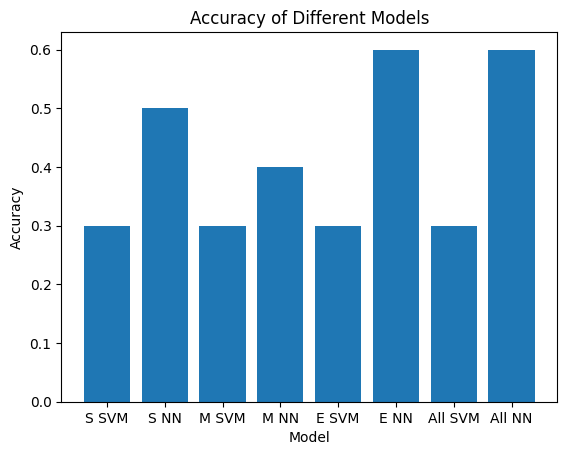

In [51]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Accuracy values
accuracy_values = [start_SVM_acc, start_NN_acc, mid_SVM_acc, mid_NN_acc, end_SVM_acc, end_NN_acc, all_SVM_acc, all_NN_acc]

# Model names
model_names = ['S SVM', 'S NN', 'M SVM', 'M NN', 'E SVM', 'E NN', 'All SVM', 'All NN']

# Parameters
parameters = [start_SVM_param, start_NN_param, mid_SVM_param, mid_NN_param, end_SVM_param, end_NN_param, all_SVM_param, all_NN_param]

# Create a table of model names and parameters
table = []
for name, param in zip(model_names, parameters):
    table.append([name, param])

# Print the table
print(tabulate(table, headers=['Model', 'Parameters'], tablefmt='grid'))

# Plot the bar graph
plt.bar(model_names, accuracy_values)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()
